In [76]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/riri/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [77]:
import json
import requests
from sklearn import decomposition
from IPython import display
import ignite
from skorch import NeuralNetClassifier, NeuralNet
from sklearn import model_selection
from torch import nn
import torch
from sklearn import cluster, pipeline
import seaborn as sns
sns.set_style('white')

In [78]:
if False:
    display.clear_output(wait=True)
    while True:
        display.clear_output(wait=True)
        res = requests.get("http://pizero.local").json()
        imshow(res['frame'], vmin=18, vmax=25)
        colorbar()
        plt.title(str(res['classif']))
        plt.show()
        display.display(plt.gcf())

In [79]:
frames = []
with open('./data.dat', 'r') as f:
    for line in f:
        try:
            frame = json.loads(line)
            frames.append(frame['frame'])
        except json.JSONDecodeError:
            print(f"Failed at {len(frames)}")
            
frames = frames[10:]

In [80]:
imshow(frames[-100])
colorbar()

IndexError: list index out of range

In [63]:
all_frames = np.array(frames).reshape(-1, 64)
all_frames = all_frames.T
all_frames -= all_frames.min(0)
all_frames /= all_frames.max(0)
all_frames = all_frames.T

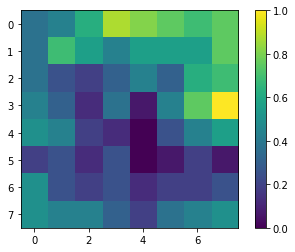

In [64]:
imshow(all_frames[-5].reshape(8,8))
colorbar()

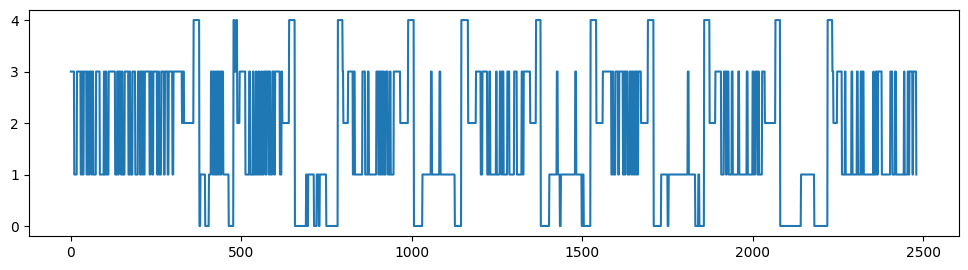

In [75]:
toob = pipeline.make_pipeline(
    decomposition.PCA(4),
    cluster.KMeans(5x)
)
whitened_frames = decomposition.PCA().fit_transform(all_frames)


decomposed_frames = toob.fit_predict(all_frames)

figure(figsize=(12, 3), dpi=100)
plot(whitened_frames[:, 0], alpha=0.2)
plot(whitened_frames[:, 1], alpha=0.2)
plot(whitened_frames[:, 2], alpha=0.2)
figure(figsize=(12, 3), dpi=100)
plot(decomposed_frames)



In [66]:
torchdata = torch.tensor(frames).view(-1, 64).float()
torchdata

tensor([[17.7500, 18.5000, 18.5000,  ..., 18.0000, 18.0000, 18.5000],
        [17.7500, 18.0000, 18.2500,  ..., 17.7500, 17.7500, 18.2500],
        [17.7500, 18.0000, 18.2500,  ..., 17.7500, 17.7500, 18.2500],
        ...,
        [18.0000, 19.0000, 18.7500,  ..., 18.5000, 18.7500, 18.5000],
        [18.0000, 19.0000, 18.7500,  ..., 18.5000, 18.7500, 18.5000],
        [18.2500, 19.2500, 19.2500,  ..., 17.7500, 18.5000, 19.2500]])

In [67]:
x = torchdata[:]
y = torchdata[:]

In [68]:
decoder = nn.Sequential(
    nn.Linear(64, 32),
    nn.PReLU(),
    nn.Linear(32, 4),
)

encoder = nn.Sequential(
    nn.Linear(4, 16),
    nn.PReLU(),
    nn.Linear(16, 64),
)

net = nn.Sequential(
    decoder,
    encoder
)

opt = torch.optim.Adam(net.parameters(), amsgrad=True)
loss = torch.nn.MSELoss()

In [69]:
x.shape, y.shape

(torch.Size([2480, 64]), torch.Size([2480, 64]))

In [70]:
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x[:1500], y[:1500]),
    batch_size=32,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x[1500:], y[1500:]),
    batch_size=32,
    shuffle=True,
)


trainer = ignite.engine.create_supervised_trainer(
    model=net,
    optimizer=opt,
    loss_fn=loss
)


val_metrics = {
    "accuracy": ignite.metrics.MeanSquaredError()
}
evaluator = ignite.engine.create_supervised_evaluator(model=net, metrics=val_metrics)

# @trainer.on(ignite.engine.Events.ITERATION_COMPLETED(every=50))
# def log_training_loss(trainer):
#     print("Epoch[{}] Loss: {:.2f}".format(trainer.state.epoch, trainer.state.output))

@trainer.on(ignite.engine.Events.EPOCH_COMPLETED(every=50))
def log_training_results(trainer):
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {} {}"
          .format(trainer.state.epoch, metrics))

trainer.run(data_loader, max_epochs=1500)

Training Results - Epoch: 50 {'accuracy': 23.514441229372608}
Training Results - Epoch: 100 {'accuracy': 21.019813101632256}
Training Results - Epoch: 150 {'accuracy': 17.924335308464205}
Training Results - Epoch: 200 {'accuracy': 16.39731971585021}
Training Results - Epoch: 250 {'accuracy': 15.417745146459463}
Training Results - Epoch: 300 {'accuracy': 14.269157752212212}
Training Results - Epoch: 350 {'accuracy': 13.364579632817483}
Training Results - Epoch: 400 {'accuracy': 12.877606310163225}
Training Results - Epoch: 450 {'accuracy': 12.451178507902185}
Training Results - Epoch: 500 {'accuracy': 12.312315586635044}
Training Results - Epoch: 550 {'accuracy': 12.101803962551818}
Training Results - Epoch: 600 {'accuracy': 12.149661753128987}
Training Results - Epoch: 650 {'accuracy': 11.908004542759487}
Training Results - Epoch: 700 {'accuracy': 11.799759627361686}
Training Results - Epoch: 750 {'accuracy': 11.873882605105031}
Training Results - Epoch: 800 {'accuracy': 11.55889688608

State:
	iteration: 70500
	epoch: 1500
	epoch_length: 47
	max_epochs: 1500
	output: 0.11890707910060883
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [93]:
figure(figsize=(12, 6), dpi=120)
plot(decoder(x).detach())
sns.despine()
plt.savefig('./encoded.png')

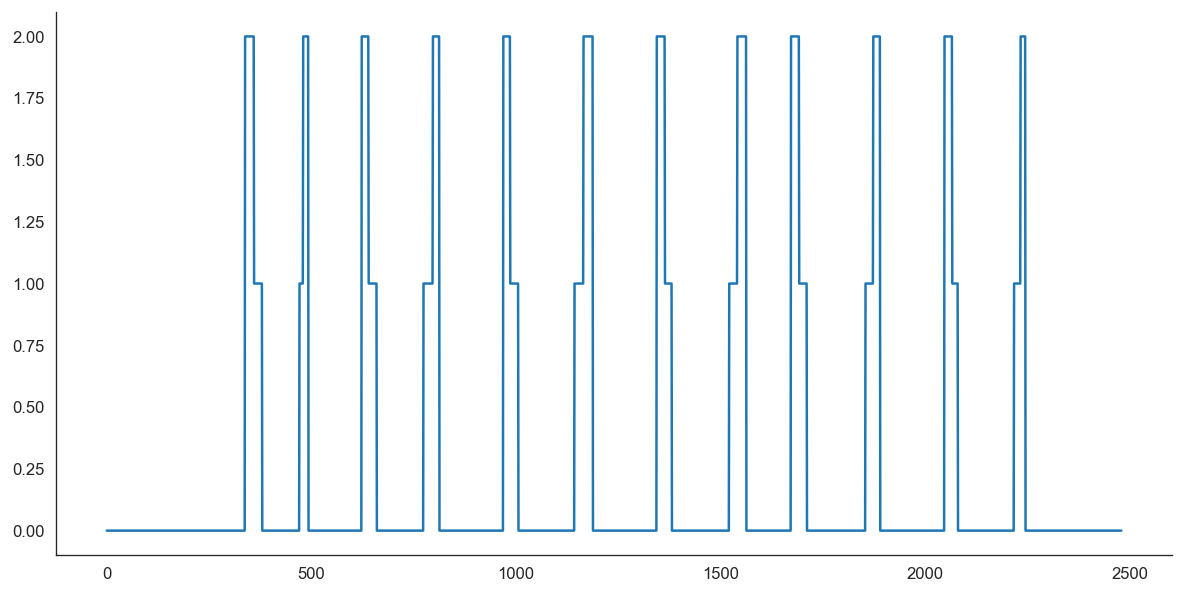

In [94]:
cls = cluster.KMeans(3).fit(decoder(x).detach())
c = cls.predict(decoder(x).detach())

figure(figsize=(12, 6), dpi=120)
plot(c)
sns.despine()
plt.savefig('./kmeans.png')

In [72]:
class KMeansLookup(nn.Module):
    def __init__(self, centroids, net):
        super().__init__()
        self.centroids = nn.Parameter(centroids)
        self.net = net
        
    def forward(self, x):
        cls_x = self.net(x)
        dists = []
        for ix, c in enumerate(self.centroids):
            dists.append(torch.norm(cls_x - c))
        dists = torch.stack(dists)
        return dists.argmin()

    
class FinalModel(nn.Module):
    def __init__(self, centroids, net):
        super().__init__()
        self.km = KMeansLookup(centroids, net)
        
    def forward(self, x, xp):
        r1 = self.km(x)
        r2 = self.km(xp)
        
        ignore_stmt = r1 * 0
        inc_stmt = ignore_stmt * 0 + 1
        dec_stmt = ignore_stmt * 0 - 1
        
        return torch.where(
            r1 == 1,
            torch.where(
                r2 == 0, 
                inc_stmt,
                torch.where(
                    r2 == 2,
                    dec_stmt,
                    ignore_stmt
                )
            ),
            ignore_stmt
        )
#         if r1 == 1:
#             if r2 == 0:
#                 return r1 * 0 + 1
#             elif r2 == 2:
#                 return r1 * 0 - 1
#         return r2 * 0

#a = FinalModel(torch.tensor(cls.cluster_centers_).float(), decoder)
a = KMeansLookup(torch.tensor(cls.cluster_centers_).float(), decoder)
fmdl = torch.jit.script(a)
r = fmdl(x[262])
print(r)

torch.onnx.export(a, x[0], 'test.onnx', verbose=True, training=False, example_outputs=r)

tensor(0)
graph(%input.1 : Float(64:1),
      %net.0.bias : Float(32:1),
      %net.1.weight : Float(1:1),
      %net.2.bias : Float(4:1),
      %39 : Float(64:1, 32:64),
      %40 : Float(32:1, 4:32),
      %41 : Float(1:4, 4:1),
      %42 : Float(1:4, 4:1),
      %43 : Float(1:4, 4:1)):
  %8 : Float(32:1) = onnx::MatMul(%input.1, %39) # /Users/riri/.pyenv/versions/3.7.3/lib/python3.7/site-packages/torch/nn/functional.py:1676:0
  %9 : Float(32:1) = onnx::Add(%8, %net.0.bias)
  %10 : Float(32:1) = onnx::PRelu(%9, %net.1.weight) # /Users/riri/.pyenv/versions/3.7.3/lib/python3.7/site-packages/torch/nn/functional.py:1319:0
  %12 : Float(4:1) = onnx::MatMul(%10, %40) # /Users/riri/.pyenv/versions/3.7.3/lib/python3.7/site-packages/torch/nn/functional.py:1676:0
  %13 : Float(4:1) = onnx::Add(%12, %net.2.bias)
  %16 : Float(4:1) = onnx::Sub(%13, %41) # <ipython-input-72-4300c352bb02>:11:0
  %17 : FloatTensor = onnx::Mul(%16, %16)
  %18 : Tensor = onnx::ReduceSum[keepdims=0](%17)
  %19 : Float

/Users/riri/.pyenv/versions/3.7.3/lib/python3.7/site-packages/torch/tensor.py:455: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  'incorrect results).', category=RuntimeWarning)


In [73]:
x

tensor([[17.7500, 18.5000, 18.5000,  ..., 18.0000, 18.0000, 18.5000],
        [17.7500, 18.0000, 18.2500,  ..., 17.7500, 17.7500, 18.2500],
        [17.7500, 18.0000, 18.2500,  ..., 17.7500, 17.7500, 18.2500],
        ...,
        [18.0000, 19.0000, 18.7500,  ..., 18.5000, 18.7500, 18.5000],
        [18.0000, 19.0000, 18.7500,  ..., 18.5000, 18.7500, 18.5000],
        [18.2500, 19.2500, 19.2500,  ..., 17.7500, 18.5000, 19.2500]])